In [73]:
from time import perf_counter
import copy
from numpy import fft, array
import random as rnd
from fpylll import *

FPLLL.set_precision(300)
RealNumber = RealField(256)
ComplexNumber = ComplexField(256)

def euclidnorm(v):
    if isinstance(v,sage.rings.complex_mpfr.ComplexNumber):
        return norm(v)
    if isinstance(v,(list,sage.modules.free_module_element.FreeModuleElement_generic_dense)):
        return(sum(euclidnorm(i)^2 for i in v))
    v_list = v.list()
    return sqrt(sum(i^2 for i in v_list))

def rfact(B):   #it works!!!
    F = B[0,0].parent()
    d = B.nrows()
    
    Q=matrix(F,d,d)
    Q[0]=B[0]
    
    i,j = 0,0
    #print(sum( (((B[j]*Q[i])/(Q[i]*Q[i]))*Q[i]) for i in range(j) ))
    for j in range(1,d):
        s = vector(F,d)
        for i in range(j):
            s+=((B[j]*Q[i])/(Q[i]*Q[i]))*Q[i]
        Q[j]=B[j]-s
    
    R=matrix(F,d,d)
    for j in range(d):
        for i in range(j+1):
            #R[i,j]=Q[i]*B[j]/(Q[i]*Q[i])
            R[i,j]=Q[i]*B[j]/(Q[i]*Q[i])
            
    return R.transpose(), Q

def ascend(K,v):
    #ascends vector to element of the field above
    v=vector(v)
    qh = len(v)
    d_ = v[0].parent().degree()
    d=d_*qh
    z_=K.gen()   
    out = sum( z_^i * v[i] for i in range(qh) )
    return(out)

def descend(K,a):   #only qh=2
    d_ = a.parent().degree()
    
    out = []
    for i in range(2):
        out.append( K(a.list()[i:d_:2]) )
    return out

def descend_rank2(K,v):
    L = v[0].parent()
    d_ = L.degree()
    d  = K.degree()
    qh=d_/d
    
    out = []
    for i in range(qh):
        out.append(K(v[0].list()[i:d_:qh]))
    for i in range(qh):
        out.append(K(v[1].list()[i:d_:qh]))
    return out

def invertibles(f):
    out=[]
    for i in range(f):
        if gcd(i,f)==1:
            out.append(i)
    return out

def minkowski_embedding(a, truncated=True):
    K = a.parent().fraction_field()
    sigmas = K.embeddings(ComplexField(240))
    
    if truncated:
        return [s(a) for s in sigmas[:len(sigmas)/2]]
    else:
        return [s(a) for s in sigmas]

def log_embedding(a,truncated=True):
    ac = minkowski_embedding(a,truncated)
    return vector(RealField(240), [ln(abs(t)) for t in ac])

def round_matrix(M):
    M_ = matrix(ZZ,M.nrows(),M.ncols())
    for i in range(M.nrows()):
        for j in range(M.ncols()):
            M_[i,j] = ZZ(M[i,j].round())
    return M_

def round_babai(B_,t, prec = 10^50, wrt_lll=False):
    
    B = (prec*B_)
    B = round_matrix(B)
    #print('target',t*prec)
    
    Bint = IntegerMatrix(B.nrows(),B.ncols())
    U=IntegerMatrix.identity(B.ncols())
    
    for i in range(B.nrows()):
        for j in range(B.ncols()):
            Bint[i,j] = B[i,j]
            
    M = GSO.Mat(Bint,  float_type='mpfr')
    lll = LLL.Reduction(M)
    lll()
    T = t*prec
    T = [ float(tmp) for tmp in T]
    v= vector(ZZ, M.babai(T) )
    if not wrt_lll:
        tmp = B.solve_left( v*matrix(ZZ,Bint) )
        #print(tmp)
        return tmp
    else:
        return v
    
def unit_reduce(a, prec=10^120, non_increase=False):
    K = a.parent().fraction_field()
    z_ = K.gen()
    f = z_.multiplicative_order()
    
    units = [z^((1-(i))/2) * (1-z_^i)/(1-z_) for i in invertibles(f/2) ]
    #units = [(z_^i-1)/(z_-1) for i in invertibles(f/2) ]
    assert all( [tmp.is_unit() for tmp in units] )
    
    va = log_embedding(a)
    V = va.parent()
    d = V.dimension()
    One = vector([1]*d)
    
    t = ( va.dot_product( One ) / d) * One
    t= va-t   #t is va projected orthogonally to vector 1
    
    assert sum( [tmp for tmp in t] ) < 10^-10

    B=matrix([
        log_embedding(units[i]) for i in range(d)
    ])

    tmp = list( round_babai(B[1:,:],t,prec=prec) )
    y=tmp
    u =  prod(( units[i+1])^-y[i] for i in range(len(units)-1))
    if not non_increase:
        return a*u
    else:
        tmp = a*u
        return a if euclidnorm(a)<euclidnorm(tmp) else tmp
    
def size_reduce(R):
    K=R[0,0].parent()
    d = R.nrows()
    U = matrix.identity(K,d)
    
    for i in range(d):
        if K.degree()>4:
            ur = unit_reduce(R[i,i],non_increase=True)
        else:
            ur = R[i,i]
            
        U[i]*=1/ur
        R[i]*=1/ur   #check
        for j in range(i-1,-1,-1): 
            r = list( R[i,j] )   
            mu = [round(tmp) for tmp in r]
            mu = K(mu)
            U[i]+=(-mu)*U[j]  
            R[i]+=(-mu)*R[j]
    return U

def GEuclide(L, Lptr,a,b):
    print('Currently at',Lptr)
        
    K = a.parent().fraction_field()
    assert K.degree()==1 or K==L[Lptr]   #assert if the pointer to the field is correct
    
    if K==QQ or K.degree()<2:
        return xgcd(a,b)[1:]
    subK = L[Lptr-1]
    a, b =K(a), K(b)
    mu, nu = GEuclide(L,Lptr-1,a.norm(subK),b.norm(subK))
    mu_, nu_ = mu * a^-1 * a.norm(subK), nu * b^-1 * b.norm(subK)
    W = matrix(K,[
        [a, b],
        [nu_,mu_]
    ])
#     print('Upwards:',Lptr)
    Q, R = rfact(W)
#     print('rfact completed')
    V = size_reduce(R)
    
# #     retrieving parasiting unit
#     nu, mu = V[1]*W 
#     unit = a*mu-b*nu
#     assert unit.is_unit()
    
    #return V[1]*W * (1/unit)
    return V[1]*W 

def descend_rank2_matrix(K,B):
    z=K.gen()
    
    a,b,c,d = descend(K,B[0,0]), descend(K,B[0,1]), descend(K,B[1,0]), descend(K,B[1,1])
    a_= [z*a[1], z*a[0]]
    b_= [z*b[1], z*b[0]]
    c_= [z*c[1], z*c[0]]
    d_= [z*d[1], z*d[0]]
    
    C = matrix(K,[
        a  + b,
        a_ + b_,
        c  + d,
        c_ + d_
    ])
    return C

def Lift(L,Lptr,v):
    K=L[Lptr]
    a,b = ascend(K,v[0:2]), ascend(K,v[2:4])
    mu, nu = GEuclide(L,Lptr,a,b)
    U = matrix(L[Lptr],[
        [a,b],
        [nu,mu]
    ])
    
    return(U)


In [150]:
def lll(L,Lptr,M, rho=5, eps=0.1, alpha=0.05):
    K=L[Lptr]
    print('DOWN: ', Lptr)
    d=M.nrows()
    n = K.degree()
     
    if n==1 and d==2 or Lptr==0:   #here should've been Schonhage or Gauss
        return(matrix.identity(d))
    
    U=matrix.identity(d)
    for i in range(rho):
        R, Q = rfact(M)
        if n>2:
            U_ = size_reduce(R)
        else:
            U_ = matrix.identity(d)
        
        M=U_*M
        R=U_*R
        U=U_*U
        
        for j in range(i%2,d,2):
            if i+1>=d or j+1>=d:
                continue
#             print(i,j,d)
            print('lol:', norm(R[j,j]) / 2^(2*(1+eps)*alpha*n^2)*norm(R[j+1,j+1]))
            if norm(R[j,j]) <= 2^(2*(1+eps)*alpha*n^2)*norm(R[j+1,j+1]):
                M_ = matrix([
                    [R[j,j], R[j,j+1]],
                    [R[j+1,j], R[j+1,j+1]]
                ])
                
                if n>1:
                    M_ = descend_rank2_matrix(L[Lptr-1],M_)
                
                U_ = lll(L,Lptr-1,M_, rho, eps, alpha)
                U__ = matrix.identity(QQ,d)
                U_ = Lift(L,Lptr-1,U_[0])
                U__[i,j], U__[i,j+1] = U__[0,0], U__[0,1]   #the big transformation matrix
                U__[i+1,j], U__[i+1,j+1] = U__[1,0], U__[1,1]
                
                M=U__*M
                R=U__*R
                U=U__*U
    print('UP',Lptr)
#     print(U)
    return U

In [155]:
from copy import deepcopy

h=3

L = [CyclotomicField(n) for n in [2,4,8,16,32,64]]
K.<z>=L[h]
OK = K.ring_of_integers()
n=3

B = matrix(K, [
    [OK.random_element(-144-55*i,1444+57*i) for j in range(n)] for i in range(n)
])

print(B)
B_save = deepcopy(B)

U = lll(L,h,B)
print(U)
print('- - -')
B=U*B
print(B)
det(U)

[    602*zeta16^7 + 1041*zeta16^6 + 361*zeta16^5 + 819*zeta16^4 + 1023*zeta16^3 + 743*zeta16^2 + 35*zeta16 + 1185   1100*zeta16^7 + 1037*zeta16^6 + 471*zeta16^5 + 772*zeta16^4 + 878*zeta16^3 + 864*zeta16^2 + 1149*zeta16 + 1169     242*zeta16^7 + 957*zeta16^6 + 1293*zeta16^5 + 821*zeta16^4 + 1139*zeta16^3 + 1223*zeta16^2 + 2*zeta16 + 1380]
[   695*zeta16^7 + 781*zeta16^6 + 1275*zeta16^5 + 1459*zeta16^4 - 67*zeta16^3 + 1232*zeta16^2 + 1316*zeta16 + 541    1088*zeta16^7 - 137*zeta16^6 + 646*zeta16^5 + 152*zeta16^4 + 284*zeta16^3 + 1288*zeta16^2 + 1093*zeta16 + 713        773*zeta16^7 + 34*zeta16^6 + 693*zeta16^5 - 68*zeta16^4 + 1069*zeta16^3 + 835*zeta16^2 + 581*zeta16 + 681]
[     514*zeta16^7 + 194*zeta16^6 + 536*zeta16^5 - 252*zeta16^4 + 923*zeta16^3 + 1498*zeta16^2 - 217*zeta16 + 581     459*zeta16^7 - 19*zeta16^6 + 361*zeta16^5 + 1556*zeta16^4 + 1537*zeta16^3 + 915*zeta16^2 + 1437*zeta16 + 939 1503*zeta16^7 + 117*zeta16^6 + 1451*zeta16^5 + 1408*zeta16^4 + 878*zeta16^3 + 1135*zeta16^2

1

In [156]:
alg0, eucl0 = [], []
alg1, eucl1 = [], []

for i in range(n):
    print('alg norm:', B_save[i].norm().n(), B[i].norm().n())
    alg0.append(B_save[i].norm().n())
    alg1.append(B[i].norm().n())
    
    print('euc norm:', euclidnorm(B_save[i]), euclidnorm(B[i]))
    eucl0.append(euclidnorm(B_save[i])^0.5)
    eucl1.append(euclidnorm(B[i]).n()^0.5)

alg norm: 7526.04809863313 7526.04809863313
euc norm: 20576288 20576288
alg norm: 6472.67632599769 8140.09013212359
euc norm: 17204559 25907119
alg norm: 8470.55494405254 3703.54577785548
euc norm: 25646702 14808061


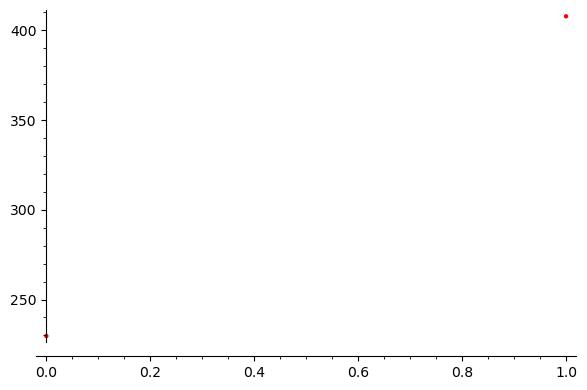

In [104]:
ep = list_plot(eucl1, color='red')
ep.show()

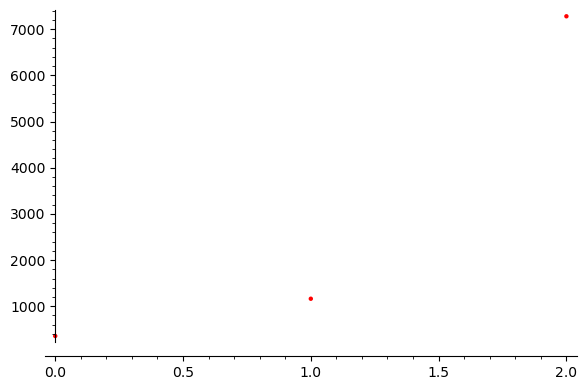

In [78]:
np =  list_plot(alg1,color='red')
np.show()

30